In [1]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
import gensim
import pickle
import zipfile
from urllib import request

import numpy as np
import pandas as pd

import seaborn as sns
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Lambda, Add, Concatenate, Multiply, Subtract, Flatten, Dropout

from tensorboard.plugins.hparams import api as hp

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from gensim.models.doc2vec import Doc2Vec

# Resets notebook state
tf.keras.backend.clear_session()

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
%matplotlib inline

In [3]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(get_available_devices())

Num GPUs Available:  0
['/device:CPU:0', '/device:XLA_CPU:0']


In [4]:
def download(url, filename, local=True):
    """Download a file if not present"""
    if not local and not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        if os.path.exists(filename):
            print("extracting {}...".format(filename))
            with zipfile.ZipFile(filename) as f:
                f.extractall()
                print("extracting {} done".format(filename))
        else:
            print('data.zip not found!')

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [5]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-recommender/', filename="data.zip", local=True)

'data'

#### Loading in data

In [6]:
n_tag = 5040
tag_max_len = 5

def load_posts():
    df = pd.read_csv('data/articles_20200304.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['idx','post_id', 'title', 'tags']
    return df[['post_id', 'title', 'tags']]

def load_posts_ctr():
    df = pd.read_csv('data/articles_doc2vec_20200304.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'related_post_id', 'ctr']
    return df

def text2seq(text, n_tag):
    """ using tokenizer to encoded the multi-level categorical feature """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_tag)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=tag_max_len,padding='post')
    return seq

#### KMeans

In [7]:
print('load kmeans model...')
kmeans_model = pickle.load(open('model/kmeans.pkl', 'rb'))
clusters = kmeans_model.labels_.tolist()
print('load kmeans model done')

load kmeans model...
load kmeans model done


##### Doc3Vec

In [8]:
print('loading doc2vec model...')
doc2vec_model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
print('loading doc2vec model done')

loading doc2vec model...
loading doc2vec model done


In [9]:
print('loading pid_post_id...')
pid_post_id = pickle.load(open('model/pid_post_id.pkl', 'rb'))
print('loading pid_post_id...')

post_id_pid = {}
for pid, post_id in pid_post_id.items():
    post_id_pid[post_id] = pid

loading pid_post_id...
loading pid_post_id...


In [10]:
# create dictionary doc-id to cluster-id
clusters_docs = {}
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}
for item in docs_clusters:
    if item[1] in clusters_docs.keys():
        clusters_docs[item[1]].append(item[0])
    else:
        clusters_docs[item[1]] = [item[0]]

In [11]:
all_posts = load_posts()
all_posts

,post_id,title,tags
0,511096,Peran dan Dampak Karbon Dioksida terhadap Tubu...,hasil lab|metabolisme
1,84485,Oksigenasi Bisa Membantu Menyembuhkan Penyakit...,asma|HIPOKSIA|ppok|sesak napas|sleep apnea
2,834460,Seperti Ini Cara Kerja Sistem Pernapasan pada ...,infeksi saluran pernapasan|sesak napas|sinusitis
3,779117,Waspadai Penyakit Penyebab Gangguan Pernapasan...,alergi|asma|sesak napas
4,631994,Penyebab Gusi Bengkak Bernanah dan Pencegahannya,radang gusi
...,...,...,...
5807,476063,Persiapan Khusus bagi Pengidap Diabetes sebelu...,demam|diabetes tipe 1|diabetes tipe 2|diabetes...
5808,439056,Atur Keuanganmu dengan Baik Agar Terhindar dar...,bunuh diri|depresi|kesehatan mental|psikologi
5809,500630,"Hidrasi Tepat, Cepat Pulihkan Flu",anak|batuk|bayi|Dehidrasi|demam|flu|orang tua|...
5810,37676,Ayo Konsumsi Makanan Berlemak Agar Tubuh Lebih...,obesitas


In [12]:
all_posts['tags'] = text2seq(all_posts.tags.values, n_tag=n_tag).tolist()
all_posts

,post_id,title,tags
0,511096,Peran dan Dampak Karbon Dioksida terhadap Tubu...,"[96, 72, 0, 0, 0]"
1,84485,Oksigenasi Bisa Membantu Menyembuhkan Penyakit...,"[57, 254, 175, 43, 190]"
2,834460,Seperti Ini Cara Kerja Sistem Pernapasan pada ...,"[80, 43, 97, 0, 0]"
3,779117,Waspadai Penyakit Penyebab Gangguan Pernapasan...,"[24, 57, 43, 0, 0]"
4,631994,Penyebab Gusi Bengkak Bernanah dan Pencegahannya,"[91, 0, 0, 0, 0]"
...,...,...,...
5807,476063,Persiapan Khusus bagi Pengidap Diabetes sebelu...,"[116, 36, 10, 79, 112]"
5808,439056,Atur Keuanganmu dengan Baik Agar Terhindar dar...,"[454, 41, 16, 8, 0]"
5809,500630,"Hidrasi Tepat, Cepat Pulihkan Flu","[52, 90, 54, 65, 73]"
5810,37676,Ayo Konsumsi Makanan Berlemak Agar Tubuh Lebih...,"[19, 0, 0, 0, 0]"


In [13]:
# lookup dictionary
post_id_title = {}
for index, row in all_posts.iterrows():
    post_id_title[row.post_id] = row.title
len(post_id_title)

5812

In [14]:
# lookup dictionary
post_id_tags = {}
for index, row in all_posts.iterrows():
    post_id_tags[row.post_id] = row.tags
len(post_id_tags)

5812

In [15]:
pids = clusters_docs[0]
post_ids = [pid_post_id[pid] for pid in pids]
len(post_ids)

544

In [16]:
# posts = all_posts[all_posts['post_id'].isin(post_ids)]
# posts
posts = all_posts
posts

,post_id,title,tags
0,511096,Peran dan Dampak Karbon Dioksida terhadap Tubu...,"[96, 72, 0, 0, 0]"
1,84485,Oksigenasi Bisa Membantu Menyembuhkan Penyakit...,"[57, 254, 175, 43, 190]"
2,834460,Seperti Ini Cara Kerja Sistem Pernapasan pada ...,"[80, 43, 97, 0, 0]"
3,779117,Waspadai Penyakit Penyebab Gangguan Pernapasan...,"[24, 57, 43, 0, 0]"
4,631994,Penyebab Gusi Bengkak Bernanah dan Pencegahannya,"[91, 0, 0, 0, 0]"
...,...,...,...
5807,476063,Persiapan Khusus bagi Pengidap Diabetes sebelu...,"[116, 36, 10, 79, 112]"
5808,439056,Atur Keuanganmu dengan Baik Agar Terhindar dar...,"[454, 41, 16, 8, 0]"
5809,500630,"Hidrasi Tepat, Cepat Pulihkan Flu","[52, 90, 54, 65, 73]"
5810,37676,Ayo Konsumsi Makanan Berlemak Agar Tubuh Lebih...,"[19, 0, 0, 0, 0]"


In [17]:
posts.sample(20)

,post_id,title,tags
4284,106979,Mengolah Daging Sapi dengan Benar,"[247, 5, 39, 1, 0]"
1674,1705107,"Mengenal Metode Bradley, Teknik Persalinan Nor...","[13, 0, 0, 0, 0]"
5758,1277867,Kapan Anak Bisa Minum Susu UHT?,"[184, 4, 1, 0, 0]"
3111,153334,9 Obat yang Belum Tentu Tepat Diberikan untuk ...,"[4, 3, 27, 400, 0]"
4768,81700,Manfaat Pepaya Bagi Kesehatan,"[5, 60, 1, 76, 0]"
4487,29756,Seperti Apa Orgasme Pria dan Wanita,"[17, 23, 32, 22, 0]"
5328,869082,Fakta Manfaat Kentang untuk Wajah,"[205, 5, 482, 76, 0]"
2765,431240,Ini Alasan Tangan Gemetar Jangan Dianggap Remeh,"[533, 739, 0, 0, 0]"
5073,344292,6 Pertanyaan Penting seputar Pemeriksaan Pap S...,"[77, 541, 0, 0, 0]"
88,1789417,4 Pilihan Vitamin Kuku yang Menjadikan Kuku An...,"[150, 560, 0, 0, 0]"


In [18]:
posts_ctr = load_posts_ctr()
print("Total Unique Posts: {}".format(posts_ctr.post_id.nunique()))
posts_ctr[['post_id','related_post_id','ctr']]

Total Unique Posts: 5842


,post_id,related_post_id,ctr
0,1659263,1303195,5
1,1659263,1241252,5
2,1659263,1301296,4
3,1659263,654207,4
4,1659263,1688329,3
...,...,...,...
58415,508878,254652,3
58416,508878,508878,2
58417,508878,109117,2
58418,508878,475528,1


In [19]:
# do some preprocessing to make sure data quality
dataset_clean_1 = posts_ctr.merge(posts, on='post_id', how='left', indicator=True)
dataset_clean_1 = dataset_clean_1[dataset_clean_1._merge == 'both']
dataset_clean_1 = dataset_clean_1.drop(['_merge'], axis=1)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"


In [20]:
# lookup dictionary
related_post_id_pid = {}
for _, row in dataset_clean_1.iterrows():
    if row.related_post_id not in related_post_id_pid.keys():
        related_post_id_pid[row.related_post_id] = post_id_pid[row.related_post_id]

In [21]:
def pid_column(row):
    if row['post_id'] in post_id_pid.keys():
        return post_id_pid[row['post_id']]
    else:
        return -1

pid = dataset_clean_1.apply(lambda row: pid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(pid=pid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['pid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782


In [22]:
def nid_column(row):
    if row['related_post_id'] in related_post_id_pid.keys():
        return related_post_id_pid[row['related_post_id']]
    else:
        return -1

nid = dataset_clean_1.apply(lambda row: nid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(nid=nid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['nid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,1775
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2618
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2557
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,3084
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,5424
...,...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4701
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2782
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4342
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2260


In [23]:
# do some preprocessing to make sure data quality
def related_title_column(row):
    if row['related_post_id'] in post_id_title.keys():
        return post_id_title[row['related_post_id']]
    else:
        return 'NONE'

related_title = dataset_clean_1.apply(lambda row: related_title_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_title=related_title.values)

dataset_clean_1 = dataset_clean_1[dataset_clean_1['related_title'] != 'NONE']
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,1775,"Operasi Tulang Belakang, Ini yang Harus Anda K..."
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2618,Kenali Apa Itu Angiografi Jantung
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2557,Ketahui Hal-hal yang Berkaitan dengan Bedah Anak
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,3084,Beragam Obat Patah Tulang yang Perlu Anda Kons...
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,5424,Mengenal Lebih Jauh Tentang Prosedur Mikrodise...
...,...,...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4701,7 Tipe Wanita yang Rentan Mengalami Keguguran
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4342,Ciri-ciri Hamil Anak Laki-laki Ini Cuma Mitos
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2260,Pekerjaan Rumah yang Harus Dihindari Ibu Hamil


In [24]:
# do some preprocessing to make sure data quality
def related_tags_column(row):
    return post_id_tags[row['related_post_id']]

related_tags = dataset_clean_1.apply(lambda row: related_tags_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_tags=related_tags.values)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title,related_tags
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,1775,"Operasi Tulang Belakang, Ini yang Harus Anda K...","[1000, 714, 612, 0, 0]"
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2618,Kenali Apa Itu Angiografi Jantung,"[544, 14, 68, 0, 0]"
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2557,Ketahui Hal-hal yang Berkaitan dengan Bedah Anak,"[750, 997, 998, 0, 0]"
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,3084,Beragam Obat Patah Tulang yang Perlu Anda Kons...,"[45, 124, 128, 160, 0]"
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,5424,Mengenal Lebih Jauh Tentang Prosedur Mikrodise...,"[888, 889, 464, 0, 0]"
...,...,...,...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4701,7 Tipe Wanita yang Rentan Mengalami Keguguran,"[59, 0, 0, 0, 0]"
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4342,Ciri-ciri Hamil Anak Laki-laki Ini Cuma Mitos,"[2, 0, 0, 0, 0]"
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2260,Pekerjaan Rumah yang Harus Dihindari Ibu Hamil,"[2, 0, 0, 0, 0]"


#### Final Dataset

In [25]:
dataset = dataset_clean_1
dataset.columns = ['post_id', 'related_post_id', 'page_view', 'title', 'tags', 'pid', 'nid', 'related_title','related_tags']
dataset = dataset[['post_id','pid','title','related_post_id','nid','related_title','related_tags','page_view']]
dataset

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
0,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1303195,1775,"Operasi Tulang Belakang, Ini yang Harus Anda K...","[1000, 714, 612, 0, 0]",5
1,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1241252,2618,Kenali Apa Itu Angiografi Jantung,"[544, 14, 68, 0, 0]",5
2,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1301296,2557,Ketahui Hal-hal yang Berkaitan dengan Bedah Anak,"[750, 997, 998, 0, 0]",4
3,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,654207,3084,Beragam Obat Patah Tulang yang Perlu Anda Kons...,"[45, 124, 128, 160, 0]",4
4,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1688329,5424,Mengenal Lebih Jauh Tentang Prosedur Mikrodise...,"[888, 889, 464, 0, 0]",3
...,...,...,...,...,...,...,...,...
58415,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,254652,4701,7 Tipe Wanita yang Rentan Mengalami Keguguran,"[59, 0, 0, 0, 0]",3
58416,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2
58417,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,109117,4342,Ciri-ciri Hamil Anak Laki-laki Ini Cuma Mitos,"[2, 0, 0, 0, 0]",2
58418,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,475528,2260,Pekerjaan Rumah yang Harus Dihindari Ibu Hamil,"[2, 0, 0, 0, 0]",1


In [26]:
dataset.sample(20)

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
964,1151621,616,Apakah Bau Cat Berbahaya untuk Ibu Hamil?,38338,4758,Kolik pada Bayi Ditandai dengan Tangisan Berja...,"[3, 0, 0, 0, 0]",3
24181,617574,1604,Ini Informasi Tepat Stimulasi Puting untuk Mem...,403813,3408,Tips Melahirkan Normal Tanpa Jahitan,"[13, 0, 0, 0, 0]",5
12435,439050,4651,Pedoman Bunda Memandikan Si Kecil Baru Lahir,150099,3807,Orang Dewasa Tidak Usah Takut Bahaya Mandi Malam,"[233, 325, 29, 0, 0]",3
50787,926003,2893,Jangan Salah Pilih Pelembap untuk Kulit Berminyak,698248,1263,Ketahui Perawatan Kulit Berminyak yang Tepat d...,"[6, 9, 0, 0, 0]",2
51867,432976,3580,Feses Berwarna Hijau Ternyata Normal,459090,822,Waspadai Bahaya di Balik Air Kencing Berbusa d...,"[96, 0, 0, 0, 0]",2
49566,341813,1274,Kadar PSA Tinggi Tidak Selalu Berarti Kanker P...,914153,2310,Kelainan Pada Hati dan Faktor Penyebab yang Pe...,"[232, 147, 353, 551, 177]",2
2638,1110269,5605,Ini Daftar Sayuran untuk Penderita Asam Urat y...,1671013,4196,Memilih Makanan yang Tepat untuk Penderita Bat...,"[187, 1, 0, 0, 0]",1
58210,191211,5327,4 Jenis Masker Wajah Alami untuk Kulit Kering,191211,5327,4 Jenis Masker Wajah Alami untuk Kulit Kering,"[10, 6, 0, 0, 0]",5
45330,1143418,4353,Spermatogenesis: Proses Pembuatan Sel Sperma,1143418,4353,Spermatogenesis: Proses Pembuatan Sel Sperma,"[17, 48, 428, 12, 0]",5
33950,391079,3461,"Operasi Kelamin: Tidak Hanya Rumit, Tapi Berisiko",391079,3461,"Operasi Kelamin: Tidak Hanya Rumit, Tapi Berisiko","[35, 645, 0, 0, 0]",5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a45159f90>],
      dtype=object)

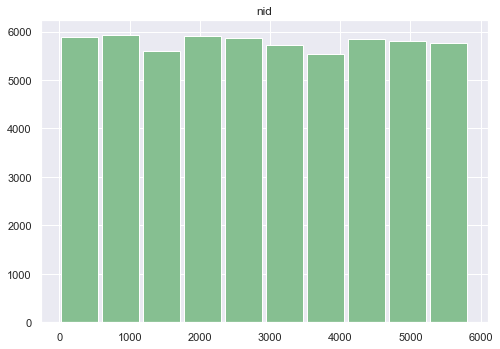

In [27]:
# Histogram
dataset.hist(column='nid', grid=True, figsize=(8,20), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

In [28]:
num_pid = len(dataset.pid.unique())
num_nid = len(dataset.nid.unique())
print('There are {} unique pid and {} unique nid in this dataset '.format(num_pid, num_nid))

There are 5812 unique pid and 5682 unique nid in this dataset 


In [29]:
pid_max = dataset.pid.max()
nid_max = dataset.nid.max()
print('There are {} distinct posts in posts-ctr and the max of pid is {}'.format(num_pid, pid_max))
print('There are {} distinct posts in posts-ctr and the max of nid is {}'.format(num_nid, nid_max))

There are 5812 distinct posts in posts-ctr and the max of pid is 5841
There are 5682 distinct posts in posts-ctr and the max of nid is 5841


#### Creating Model

##### Define Input Layers

In [30]:
def define_input_layers():
    # single level categorical features
    pid_input = Input((1,), name='input_pid')
    nid_input = Input((1,), name='input_nid')
    cat_sl_inputs = [pid_input, nid_input]
    
    # multi level categorical features (with tag_max_len tags at most)
    tag_input = Input((tag_max_len,), name='input_tag')
    cat_ml_inputs = [tag_input]
    
    inputs = cat_sl_inputs + cat_ml_inputs
    return inputs

In [31]:
def Tensor_Mean_Pooling(name='mean_pooling', keepdims=False):
    return Lambda(lambda x: K.mean(x, axis=1, keepdims=keepdims), name=name)

def fm_1d(inputs, n_pid, n_nid, n_tag):
    pid_input, nid_input, tag_input = inputs
    
    # all tensors are reshape to (None, 1)
    cat_sl_embed_1d = [Embedding(n_pid + 1, 1, name='cat_embed_1d_pid')(pid_input),
                       Embedding(n_nid + 1, 1, name='cat_embed_1d_nid')(nid_input)]
    cat_ml_embed_1d = [Embedding(n_tag + 1, 1, mask_zero=True, name='cat_embed_1d_term')(tag_input)]
    
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name='fm_1d_output')(cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

In [32]:
def fm_2d(inputs, n_pid, n_nid, n_tag, k):
    pid_input, nid_input, tag_input = inputs
    
    cat_sl_embed_2d = [Embedding(n_pid + 1, k, name='cat_embed_2d_pid')(pid_input),
                       Embedding(n_nid + 1, k, name='cat_embed_2d_nid')(nid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_tag + 1, k, name = 'cat_embed_2d_tag')(tag_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_tag_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)
    
    # concatenate all 2d embed layers => (None, 4, k)
    embed_2d = Concatenate(axis=1, name='concat_embed_2d')(cat_sl_embed_2d + cat_ml_embed_2d)
    
    # calcuate the interactions by simplication: sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis=1), name='sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name='square_of_tensors')
    
    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name='fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

In [33]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

In [34]:
def deep_fm_model(n_pid, n_nid, n_tag, k, dnn_dim, dnn_dr):
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_pid, n_nid, n_tag)
    y_fm_2d, embed_2d = fm_2d(inputs, n_pid, n_nid, n_tag, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name='deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

In [35]:
params = {
    'n_pid': pid_max,
    'n_nid': nid_max,
    'n_tag': n_tag,
    'k': 20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}
fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

In [36]:
from sklearn.preprocessing import StandardScaler

def df2xy(data):
    x = [data.pid.values,
         data.nid.values,
         np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]
    
    scaler = StandardScaler()
    standardized = scaler.fit_transform(data.page_view.values.reshape(-1, 1))
    y = standardized.flatten()
    return x,y

# def df2xy(data):
#     x = [data.pid.values,
#          data.nid.values,
#          np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]
#     y = data.page_view.values
#     return x,y

train_data, valid_data = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=99)
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

In [37]:
training = True
if not training and os.path.exists('model/deepfm_weights-ctr.h5'):
    deep_fm_model = deep_fm_model.load_weights('model/deepfm_weights-ctr.h5')
else:
    # train  model
    with tf.device('/device:CPU:0'):
        deep_fm_model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.001))
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        model_ckp = ModelCheckpoint(filepath='model/deepfm_weights-ctr.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
        callbacks = [model_ckp, early_stop]
        train_history = deep_fm_model.fit(train_x, train_y, epochs=10000, batch_size=2048, validation_split=0.1, callbacks=callbacks)

Train on 26059 samples, validate on 2896 samples
Epoch 1/10000
26059/26059 [==============================] - 1s 38us/sample - loss: 1.0032 - val_loss: 0.9810
Epoch 2/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9966 - val_loss: 0.9821
Epoch 3/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9904 - val_loss: 0.9826
Epoch 4/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9830 - val_loss: 0.9839


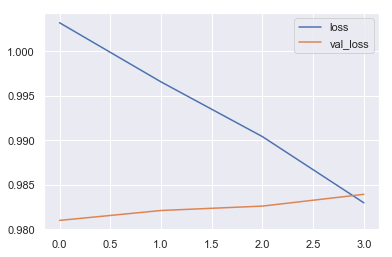

In [38]:
pd.DataFrame(train_history.history).plot()

In [39]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))


contribution of different part of model
    weight of 1st order fm: 0.586
    weight of 2nd order fm: 0.952
    weight of dnn part: -0.383



##### Model Evaluation

In [40]:
with tf.device('/device:CPU:0'):
    deep_fm_model.evaluate(valid_x, valid_y)

28956/28956 [==============================] - 1s 23us/sample - loss: 1.0060


#### Recommendations

In [41]:
posts.sample(20)

,post_id,title,tags
1525,442840,6 Manfaat Air Lemon Hangat di Pagi Hari,"[10, 1, 0, 0, 0]"
4311,69279,Benarkah Pola Makan Food Combining Lebih Menye...,"[5, 1, 19, 0, 0]"
3221,18141,Hamil 1 Bulan: Perubahan Hormon dan Morning Si...,"[2, 0, 0, 0, 0]"
328,126033,Hitung Tanggal Kelahirannya dengan Kalkulator ...,"[2, 62, 0, 0, 0]"
5431,1142788,Gangguan Fungsi Hati: Ketahui Gejala dan Pence...,"[213, 551, 234, 192, 177]"
465,4433,Memahami Nilai Nutrisi Melalui Label Produk,"[154, 130, 1, 124, 14]"
407,1403151,Tubuh Terasa Lelah Saat Bangun Tidur? Ini Peny...,"[44, 49, 0, 0, 0]"
4229,105199,Tips Merawat Kecantikan Wanita Sebelum Tidur,"[6, 106, 0, 0, 0]"
3954,206826,Deretan Obat Alami untuk Mengecilkan Batu Ginjal,"[115, 10, 0, 0, 0]"
4878,1189054,Kapan Saat Tepat Menjalin Hubungan Baru Setela...,"[21, 8, 0, 0, 0]"


##### See on rating data

In [62]:
post_id = 140628
dataset[dataset['post_id'] == post_id]

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
13190,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",140628,759,"Hentikan Procrastination, Raih Semangat Kerja!","[8, 0, 0, 0, 0]",5
13191,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",185157,504,Ada 5 Cara Agar Lebih Bahagia di Kantor,"[8, 31, 0, 0, 0]",5
13192,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",568577,2254,Cara Positif Mengelola Rasa Frustasi,"[16, 8, 0, 0, 0]",4
13193,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",1735906,400,Beragam Cara Menghilangkan Stres di Tempat Kerja,"[153, 8, 31, 0, 0]",4
13194,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",115033,4820,Fakta Pernikahan yang Perlu Diketahui Calon Pe...,"[21, 8, 0, 0, 0]",3
13195,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",507952,3950,"Hati-Hati, Stres Berat di Tempat Kerja Memicu ...","[8, 31, 0, 0, 0]",3
13196,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",203027,3327,Tips Mempertahankan Pernikahan Setelah Diselin...,"[21, 8, 0, 0, 0]",2
13197,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",858503,5838,Gaya Hidup Sehat Bisa Anda Mulai Sekarang,"[5, 16, 1, 11, 49]",2
13198,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",75945,4275,Atasi Stres Kerja dengan Kecerdasan Emosional,"[41, 8, 242, 0, 0]",1
13199,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",155654,1633,Dampak Putus Cinta bagi Kesehatan dan Cara Men...,"[41, 16, 8, 0, 0]",1


##### Find Similarity based on Document to Vector

In [63]:
pid = post_id_pid[post_id]
sims = doc2vec_model.docvecs.most_similar([doc2vec_model[pid]], topn=20)
nids = [nid for nid,_ in sims]
most_similars = dataset[dataset['nid'].isin(nids)].drop_duplicates(subset='nid', keep='last')
most_similars[['related_post_id','nid','related_title','page_view']]

,related_post_id,nid,related_title,page_view
40284,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",3
43460,391036,4071,Cara Menghilangkan Pikiran Negatif Agar Hidup ...,5
43469,1356659,4198,Berbicara Pada Diri Sendiri Ternyata Punya Man...,1
43636,499701,3139,5 Prinsip Parenting Membentuk Karakter Positif...,2
45264,149793,5175,Cara Menenangkan Pikiran Ini Bisa Meredakan Am...,3
51198,1334458,3023,Benarkah Terlalu Sering Mengakses Media Sosial...,1
51597,185157,504,Ada 5 Cara Agar Lebih Bahagia di Kantor,2
52826,826348,4431,Ini Cara Menjadi Pribadi yang Selalu Optimis,2
53512,489835,5038,Inilah Cara Tepat Hidup Bahagia Demi Kesehatan...,4
55112,15545,563,Pertolongan untuk Mencegah Seseorang Bunuh Diri,4


##### Scoring based on PageViews Collaborative Filtering

In [64]:
# Creating dataset for making recommendations
nids = most_similars.nid.values
pred = [np.array([pid for i in range(len(nids))]),
        nids,
        np.array([dataset[dataset.nid == nid].related_tags.values[0] for nid in nids])]
predictions = deep_fm_model.predict(pred)
predictions = np.array([a[0] for a in predictions])
recommended_ids = (-predictions).argsort()[:20]

recommendations = pd.DataFrame()
nids = [nids[idx] for idx in recommended_ids]
for nid in nids:
    recommendations = recommendations.append(dataset[dataset['nid'] == nid])
recommendations[['related_post_id','nid','related_title','page_view']].drop_duplicates(subset='nid', keep='last')

,related_post_id,nid,related_title,page_view
51597,185157,504,Ada 5 Cara Agar Lebih Bahagia di Kantor,2
43636,499701,3139,5 Prinsip Parenting Membentuk Karakter Positif...,2
56130,52467,658,Alasan Kenapa Tertawa Bisa Menghapus Stres,5
51198,1334458,3023,Benarkah Terlalu Sering Mengakses Media Sosial...,1
55272,1056031,1879,"Ambil Manfaat Menulis untuk Kesehatan, Ini Car...",4
43469,1356659,4198,Berbicara Pada Diri Sendiri Ternyata Punya Man...,1
45264,149793,5175,Cara Menenangkan Pikiran Ini Bisa Meredakan Am...,3
40284,140628,759,"Hentikan Procrastination, Raih Semangat Kerja!",3
57565,313357,1066,Tips Mengatasi Stres Kerja,3
55112,15545,563,Pertolongan untuk Mencegah Seseorang Bunuh Diri,4
